# Explaining the Predictions of the VGG-16 Network

In this homework, we would like to implement different explanation methods on the VGG-16 network used for image classification. As a test example, we take some image of a castle

![](castle.jpg)

and would like to explain why the VGG:16 neuron `castle` activates for this image. The code below loads the image and normalizes it, loads the model, and identifies the output neuron corresponding to the class `castle`.

In [2]:
import numpy as np
import cv2
import torch
import torch.nn
import utils

# Load image
img = np.array(cv2.imread('castle.jpg'))[..., ::-1] / 255.0
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
X = (torch.FloatTensor(img[np.newaxis].transpose([0, 3, 1, 2]) * 1) - mean) / std

# Load VGG-16 network
import torchvision
model = torchvision.models.vgg16(pretrained=True);
model.eval();

# Identify neuron "castle"
cl = 483

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/moritzgerster/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

## Gradient$\,\times\,$Input (15 P)

A simple method for explanation is Gradient$\,\times\,$Input. Denoting $f$ the function corresponding to the activation of the desired output neuron, and $\boldsymbol{x}$ the data point for which we would like to explain the prediction, the method assigns feature relevance using the formula

$$
R_i = [\nabla f(\boldsymbol{x})]_i \cdot x_i
$$

for all $i=1\dots d$. When the neural network is piecewise linear and positively homogeneous, the method delivers the same result as one would get with a Taylor expansion at reference point $\widetilde{\boldsymbol{x}} = \varepsilon \cdot \boldsymbol{x}$ with $\varepsilon$ almost zero.

**Task:**

* **Implement Gradient$\,\times\,$Input, i.e. write a function that produces a tensor of same dimensions as the input data and that contains the scores $(R_i)_i$, test it on the given input image, and visualize the result using the function `utils.visualize`. **

/Users/moritzgerster/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


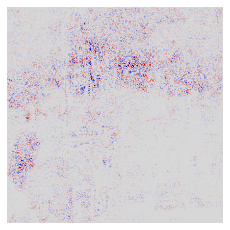

In [3]:
%matplotlib inline

X.grad = None
X.requires_grad_(True)

model.forward(X)[0, cl].backward()

R = X * X.grad

utils.visualize(R)

We observe that the explanation is noisy and has a large amount of positive and negative evidence. To produce a more robust explanation, we would like to use instead LRP, and implement it using the trick described in the slides. The trick consists of detaching certain terms from the differentiation graph, so that the explanation can obtained by performing Gradient $\times$ Input with the modified gradient.

LRP rules are typically set different at each layer. In VGG-16, we distinguish the following three types of layers of parameters:

* **First convolution:** This convolution receives pixels as input, and it requires a special rewrite rule that we given below.
* **Next convolutions:** All remaining convolutions receives activations as input, and we can treat them using LRP-$\gamma$.
* **Dense layers:** For these layers, we want to let the standard gradient signal flow, so we can simply leave these layers intact.

## LRP in First Convolution

This convolution implements the propagation rule:

$$
R_i = \sum_j \frac{x_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-}{\sum_{0,i} x_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-} R_j
$$

where $(\cdot)^+$ and $(\cdot)^-$ are shortcut notations for $\max(0,\cdot)$ and $\min(0,\cdot)$, $x_i$ the value of pixel $i$, and where $l_i$ and $h_i$ denote lower and upper-bounds on pixel values. To implement this rule using the proposed approach, we define the quantities $p_j = x_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-$ and $z_j = x_i w_{ij}$ and perform the reassignation:

$$
z_j \gets p_j \cdot [z_j / p_j]_\text{cst.}
$$

This is done by the code below

In [4]:
class ConvPx(torch.nn.Module):
    def __init__(self, conv):
        torch.nn.Module.__init__(self)
        self.conv  = conv
        self.pconv = utils.newlayer(conv, lambda p: p.clamp(min=0))
        self.nconv = utils.newlayer(conv, lambda p: p.clamp(max=0))

    def forward(self, X):
        X, L, H = X
        z = self.conv.forward(X)
        zp = z - self.pconv.forward(L) - self.nconv.forward(H)
        return zp * (z / zp).data

## LRP in Next Convolutions (15 P)

In the next convolutions, we would like to apply the LRP-$\gamma$ rule given by:
$$
R_j = \sum_k \frac{a_j (w_{jk} + \gamma w_{jk}^+)}{\sum_{0,j} a_j (w_{jk} + \gamma w_{jk}^+)} R_k
$$
To implement this rule using the proposed approach, we define the quantities $p_k = a_j (w_{jk} + \gamma w_{jk}^+)$ and $z_k = a_j w_{jk}$ and perform the reassignation:
$$
z_k \gets p_k \cdot [z_k / p_k]_\text{cst.}
$$

**Task:**

* **Inspired by the code for the first convolution, implement a class for the next convolutions that is equiped to perform the LRP-$\gamma$ propagation when calling the gradient.**

In [5]:
class Conv(torch.nn.Module):
    
    def __init__(self, conv, gamma):
        torch.nn.Module.__init__(self)
        self.conv  = conv
        self.pconv = utils.newlayer(conv, lambda p: p + gamma * p.clamp(min=0))

    def forward(self, X):
        z = self.conv.forward(X)
        zp = self.pconv.forward(X)
        
        return zp * (z / zp).data

Now, we can create the LRP-enabled model by replacing the convolution layers with their modified versions.

In [7]:
lrpmodel = torchvision.models.vgg16(pretrained=True);
model.eval()
features = lrpmodel._modules['features']
for i in [0]:        features[i] = ConvPx(features[i])
for i in [2]:        features[i] = Conv(features[i], 10**(-0.0))
for i in [5, 7]:      features[i] = Conv(features[i], 10**(-0.5))
for i in [10, 12, 14]: features[i] = Conv(features[i], 10**(-1.0))
for i in [17, 19, 21]: features[i] = Conv(features[i], 10**(-1.5))
for i in [24, 26, 28]: features[i] = Conv(features[i], 10**(-2.0))

Note that for the layer $0$ and for the subsequent layers, we have used two different classes. Also, the parameter $\gamma$ is set high in the lower layers and goes increasingly closer to zero as we reach the top convolutions.


We then proceed like Gradient$\,\times\,$Input, except for the fact that in the modified first convolution the inputs and gradients not only comprise the pixels $x$ but also the lower and upper bounds $l$ and $h$. The code below implements this extended Gradient$\,\times\,$Input and visualizes the resulting explanation.

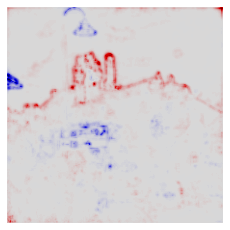

In [9]:
# Prepare data and lower/upper bounds
X.grad = None
L = (X*0 + ((0-mean) / std).view(1, 3, 1, 1)).data
H = (X*0 + ((1-mean) / std).view(1, 3, 1, 1)).data
X.requires_grad_(True)
L.requires_grad_(True)
H.requires_grad_(True)

# Apply the modfied gradient x input
lrpmodel.forward((X, L, H))[0, cl].backward()
R = (X*X.grad + L*L.grad + H*H.grad)

%matplotlib inline
utils.visualize(R)

We observe that most of the noise has disappeared, and we can clearly see in red which patterns in the data the neural network has used to predict 'castle'. We also see in blue which patterns contribute negatively to that class, e.g. the corner of the roof and the traffic sign.